In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt

import torch

from gluonts.dataset.artificial import recipe as rcp
from gluonts.dataset.artificial import RecipeDataset
from gluonts.dataset.common import ListDataset, MetaData
from gluonts.evaluation import make_evaluation_predictions, Evaluator

from pts.model.n_beats import NBEATSEstimator
from pts.model.n_beats.n_beats_X_estimator import NbeatsXEstimator
from pts import Trainer

In [2]:
NUM_EPOCHS = 30
NUM_BATCHES_PER_EPOCH = 16
NUM_SAMPLES = 10
BATCH_SIZE = 32 * 2
LEARNING_RATE = 1e-4


TIME_SERIE_LENGTH = 4 * 12 
PREDICTION_LENGTH = 4 
NUMBER_OF_TIME_SERIES = NUM_BATCHES_PER_EPOCH * BATCH_SIZE 

META_DATA = MetaData(freq="W", prediction_length=PREDICTION_LENGTH)

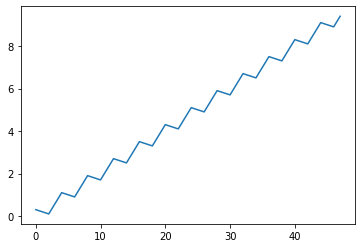

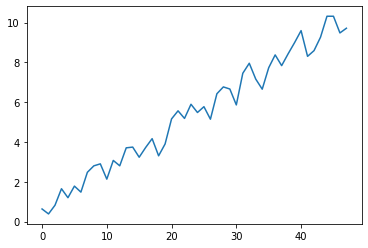

In [3]:
class SimpleDiscount(rcp.Lifted):
    def __call__(self, x, length, *args, **kwargs):
        return np.random.uniform(0, 0.7, size=length)  

class SimpleTarget(rcp.Lifted):

    def __call__(self, x, length, *args, **kwargs):
        trend = np.arange(length)  
        season = np.asarray([np.cos(2 * np.pi * i * 1/4) for i in range(length)])
        return 0.2 * trend + .3 * season

    
class SimpleElasticTarget(rcp.Lifted):

    def __call__(self, x, length, *args, **kwargs):
        trend = np.arange(length)  
        season = np.asarray([np.cos(2 * np.pi * i * 1/4) for i in range(length)])
        return 0.2 * trend + .3 * season + 2. * x
    
discounts = SimpleDiscount()(x=None, length=TIME_SERIE_LENGTH)  
    
plt.figure()
plt.plot(SimpleTarget()(x=None, length=TIME_SERIE_LENGTH))
plt.show()

plt.figure()
plt.plot(SimpleElasticTarget()(x=discounts, length=TIME_SERIE_LENGTH))
plt.show()


In [4]:
list_for_dataset = []
for _ in range(NUMBER_OF_TIME_SERIES):
    discounts = SimpleDiscount()(x=None, length=TIME_SERIE_LENGTH)
    sales = SimpleTarget()(x=None, length=TIME_SERIE_LENGTH)  
    list_for_dataset.append({
        "feat_dynamic_real": [discounts], 
        "target": sales, 
        "start": "2019-01-07 00:00"}
    )

simple_dataset = ListDataset(list_for_dataset, freq=META_DATA.freq)

In [5]:
list_for_dataset = []
for _ in range(NUMBER_OF_TIME_SERIES):
    discounts = SimpleDiscount()(x=None, length=TIME_SERIE_LENGTH)
    sales = SimpleElasticTarget()(x=discounts, length=TIME_SERIE_LENGTH)
    
    list_for_dataset.append({
        "feat_dynamic_real": [discounts], 
        "target": sales, 
        "start": "2019-01-07 00:00"}
    )

elastic_dataset = ListDataset(list_for_dataset, freq=META_DATA.freq)

In [6]:
def train_nbeats(estimator, dataset):
    predictor = estimator.train(dataset)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,  # test dataset
        predictor=predictor,  # predictor
        num_samples=NUM_SAMPLES,  # number of sample paths we want for evaluation
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    evaluator = Evaluator()
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset))
    return agg_metrics["NRMSE"]


In [7]:
nbeats_estimator = NBEATSEstimator(
    freq=META_DATA.freq,
    prediction_length=META_DATA.prediction_length,
    context_length=META_DATA.prediction_length * 3,
    trainer=Trainer(device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                    epochs=NUM_EPOCHS,
                    learning_rate=LEARNING_RATE,
                    num_batches_per_epoch=NUM_BATCHES_PER_EPOCH,
                    batch_size=BATCH_SIZE,
                    ),
    num_stacks=30,
    num_blocks=[1],
    num_block_layers=[4],
    stack_types=["G"],
    widths=[512],
    sharing=[False],
    expansion_coefficient_lengths=[32]
)

In [8]:
nbeats_X_estimator = NbeatsXEstimator(
    freq=META_DATA.freq,
    prediction_length=META_DATA.prediction_length,
    context_length=META_DATA.prediction_length * 3,
    trainer=Trainer(device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                    epochs=NUM_EPOCHS,
                    learning_rate=LEARNING_RATE,
                    num_batches_per_epoch=NUM_BATCHES_PER_EPOCH,
                    batch_size=BATCH_SIZE,
                    ),
    num_stacks=30,
    num_blocks=[1],
    num_block_layers=[4],
    stack_types=["G"],
    widths=[512],
    sharing=[False],
    expansion_coefficient_lengths=[32],
    num_feat_dynamic_real=4,
    use_feat_dynamic_real=True,
)

## Nbeats X

In [9]:
train_nbeats(nbeats_X_estimator, elastic_dataset)

  0%|          | 0/15 [00:00<?, ?it/s]

/home/kashif/.env/pytorch/lib/python3.8/site-packages/gluonts/dataset/common.py:323: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/home/kashif/.env/pytorch/lib/python3.8/site-packages/gluonts/dataset/common.py:326: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/home/kashif/.env/pytorch/lib/python3.8/site-packages/gluonts/dataset/common.py:337: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return timestamp.freq.rollforward(timestamp)
/home/kashif/.env/pytorch/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/.env/pytorch/lib/python3.8/site-packages/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq i

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Running evaluation: 100%|█████████████████| 1024/1024 [00:00<00:00, 3568.67it/s]/home/kashif/.env/pytorch/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/.env/pytorch/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/.env/pytorch/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/.env/pytorch/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecas

0.03130377492264345

## Nbeats 

In [10]:
train_nbeats(nbeats_estimator, elastic_dataset)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Running evaluation: 100%|█████████████████| 1024/1024 [00:00<00:00, 3426.40it/s]/home/kashif/.env/pytorch/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/.env/pytorch/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/.env/pytorch/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/.env/pytorch/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecas

0.04715548538551974